In [ ]:
%tensorflow_version 2.x

In [ ]:
!pip install transformers

     |████████████████████████████████| 675kB 3.4MB/s 
     |████████████████████████████████| 1.1MB 15.5MB/s 
     |████████████████████████████████| 890kB 25.2MB/s 
     |████████████████████████████████| 3.8MB 25.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=b81f5161c2a53fa551b0b0aef81f01aff3b42d6dea983812c6c24e49b1b87fb1
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import tensorflow_datasets as tfds
from transformers import BertTokenizer
from transformers.data.processors.squad import SquadResult, SquadV1Processor
from absl import app
import tensorflow_hub as hub
from tensorflow.keras.layers import Layer
import os

In [ ]:
!pip install pyyaml h5py  

In [ ]:
class BertLayer(tf.keras.layers.Layer):
   def __init__(
      self,
      bert_path="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
      **kwargs
   ):
      self.n_fine_tune_layers = 3
      self.trainable  = True
      #self.output_size = 768
      self.bert_path = bert_path

      super(BertLayer, self).__init__(**kwargs)

   def build(self, input_shape):
      self.bert = hub.load(
         self.bert_path
      )

      # Remove unused layers
      trainable_vars = self.bert.variables
      trainable_layers = []
      non_trainable_layers = []

      # Select how many layers to fine tune
      for i in range(self.n_fine_tune_layers):
         trainable_layers.append("encoder/layer_{}".format(11 - i))

      # Update trainable vars to contain only the specified layers
      non_trainable_vars = [
         var
         for var in trainable_vars
            if all([l not in var.name for l in trainable_layers])
      ]

      trainable_vars = [
         var
         for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
      ]
      
      for var in trainable_vars:
         self._trainable_weights.append(var)


      for var in non_trainable_vars:
            self._non_trainable_weights.append(var)

      super(BertLayer, self).build(input_shape)

   def call(self, inputs):
      inputs = [K.cast(x, dtype="int32") for x in inputs]
      input_ids, input_mask, segment_ids = inputs
      bert_inputs = [
         input_ids, input_mask, segment_ids
      ]
      out = self.bert(inputs=bert_inputs)[1]
      return out
   

In [ ]:
def build_model(max_seq_length, learning_rate):
   tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
   vocab_size = len(tokenizer.get_vocab())

   input_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")  
   input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
   segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

   emb = tf.keras.layers.Embedding(input_dim=128, output_dim=128, mask_zero=True)
   bert_inputs = [input_ids, input_mask, segment_ids]
   bert_output = BertLayer()(bert_inputs)

   dense = tf.keras.layers.Dense(vocab_size, activation='softmax')
   td = tf.keras.layers.TimeDistributed(dense, input_shape=(max_seq_length, 768))(bert_output, mask=emb.compute_mask(input_mask))

   model = tf.keras.models.Model(inputs=bert_inputs, outputs=td)
   model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
   model.summary()

   return model

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'.


INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1, Total size: 423.26MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert_layer (BertLayer)          (None, None, 768)    109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

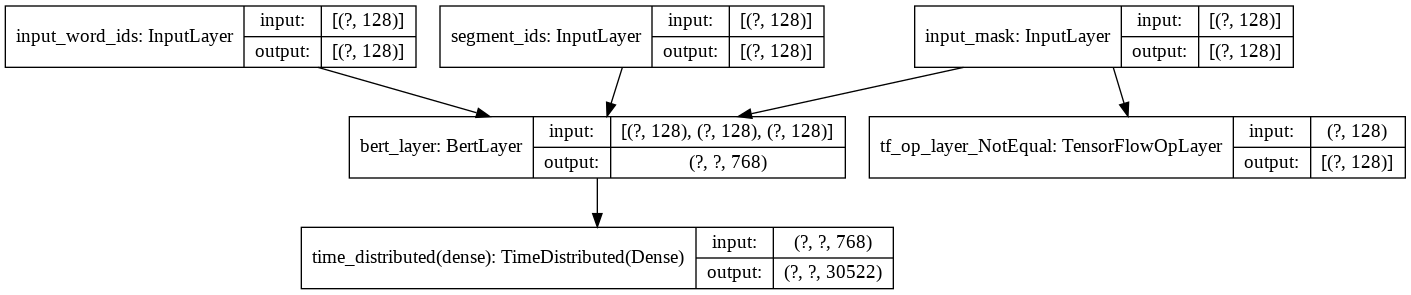

In [ ]:
model = build_model(128, 0.00005)
tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True)


In [ ]:
def load_data():
    data, info = tfds.load("squad", with_info=True)
    print(info)
    data = SquadV1Processor().get_examples_from_dataset(data, evaluate=False)
    return data

In [ ]:
def extract_and_tokenize(data, max_seq_length):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    get_questions = lambda q: q.question_text
    get_answers = lambda q: q.answer_text

    answers = tokenize(data, get_answers)
    questions = tokenize(data, get_questions)
    masks = []
    segments = []
    answers_input = []

    for i in range(len(data)):
       mask = []
       segment = []
       answer = []

       answer.extend(questions[i] + answers[i][1:])
       answers_input.append(answer)

       segment.extend([0] * len(questions[i]))
       segment.extend([1] * (len(answers[i]) - 1))
       segment.extend([0] * (max_seq_length - len(segment)))
       segments.append(segment)

       questions[i].extend(["[MASK]"] * (len(answers[i]) - 2) + ["[SEP]"])
       mask.extend([1] * len(questions[i]))
       mask.extend([0] * (max_seq_length - len(mask)))
       masks.append(mask)


    questions = map(lambda q: tokenizer.convert_tokens_to_ids(q), questions)
    questions = list(questions)
    answers = map(lambda q: tokenizer.convert_tokens_to_ids(q), answers_input)
    
    answers = list(answers)

    for i in range(len(data)):
       questions[i].extend([0] * (max_seq_length - len(questions[i])))
       answers[i].extend([0] * (max_seq_length - len(answers[i])))

    return questions, masks, segments, answers

In [ ]:
def extract_and_tokenize_v2(data, max_seq_length):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    get_questions = lambda q: q.question_text
    get_answers = lambda q: q.answer_text

    answers = tokenize_v2(data, get_answers)
    questions = tokenize_v2(data, get_questions)
    masks = []
    segments = []
    answers_input = []

    for i in range(len(data)):
       mask = []
       segment = []
       answer = []

       answer.extend(questions[i] + ["[SEP]"] + answers[i][1:])
       answer.extend(["[PAD]"] * (21 - len(answers[i])) + ["[SEP]"])
       answers_input.append(answer)

       segment.extend([0] * len(questions[i]) + [0])
       segment.extend([1] * 21)
       segment.extend([0] * (max_seq_length - len(segment)))
       segments.append(segment)

       questions[i].extend(["[SEP]"] + ["[MASK]"] * 20 + ["[SEP]"])
       mask.extend([1] * len(questions[i]))
       mask.extend([0] * (max_seq_length - len(mask)))
       masks.append(mask)

    questions = map(lambda q: tokenizer.convert_tokens_to_ids(q), questions)
    questions = list(questions)
    answers = map(lambda q: tokenizer.convert_tokens_to_ids(q), answers_input)
    
    answers = list(answers)

    for i in range(len(data)):
       questions[i].extend([0] * (max_seq_length - len(questions[i])))
       answers[i].extend([0] * (max_seq_length - len(answers[i])))
    
    return questions, masks, segments, answers

In [ ]:
def tokenize(data, function):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    data = map(function, data)
    data = list(data)
    data = map(tokenizer.tokenize, data)
    data = list(data)
    result = []
    for item in data:
        tokens = []
        tokens.append("[CLS]")
        tokens.extend(item)
        tokens.append("[SEP]")
        result.append(tokens)

    return result

In [ ]:
def tokenize_v2(data, function):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    data = map(function, data)
    data = list(data)
    data = map(tokenizer.tokenize, data)
    data = list(data)
    result = []
    for item in data:
        tokens = []
        tokens.append("[CLS]")
        tokens.extend(item)
        result.append(tokens)

    return result

In [ ]:
def tokenize_test(data, function):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    data = map(function, data)
    data = list(data)
    data = map(tokenizer.tokenize, data)
    data = list(data)
    result = []
    for item in data:
        tokens = []
        tokens.extend(item)
        result.append(tokens)

    return result


In [ ]:
def prep_test(data, max_seq_length):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    get_questions = lambda q: q.question_text
    get_answers = lambda q: q.answer_text

    answers = tokenize(data, get_answers)
    questions = tokenize(data, get_questions)
    masks = []
    segments = []

    for i in range(len(data)):
       mask = []
       segment = []

       segment.extend([0] * len(questions[i]))
       segment.extend([1] * (len(answers[i]) - 1))
       segment.extend([0] * (max_seq_length - len(segment)))
       segments.append(segment)

       questions[i].extend(["[MASK]"] * (len(answers[i]) - 2) + ["[SEP]"])
       mask.extend([1] * len(questions[i]))
       mask.extend([0] * (max_seq_length - len(mask)))
       masks.append(mask)


    questions = map(lambda q: tokenizer.convert_tokens_to_ids(q), questions)
    questions = list(questions)
    answers = tokenize_test(data, get_answers)
    answers = map(lambda q: tokenizer.convert_tokens_to_ids(q), answers)
    
    answers = list(answers)

    for i in range(len(data)):
       questions[i].extend([0] * (max_seq_length - len(questions[i])))

    return questions, masks, segments, answers

In [ ]:
def prepare_input(input_ids, masks, segments, answers):   
    input_masks = np.asarray(masks)
    input_segments = np.asarray(segments)
    input_ids = np.asarray(input_ids)
    answers = np.asarray(answers)

    return [input_ids, input_masks, input_segments], answers

In [ ]:
data = load_data()

INFO:absl:No config specified, defaulting to first: squad/plain_text
INFO:absl:Load pre-computed datasetinfo (eg: splits) from bucket.
INFO:absl:Loading info from GCS for squad/plain_text/1.0.0
INFO:absl:Generating dataset squad (/root/tensorflow_datasets/squad/plain_text/1.0.0)


INFO:absl:Downloading https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json into /root/tensorflow_datasets/downloads/rajpurkar_SQuAD-explorer_train-v1.1uLsZc14btZFRCgHMAy9Mn5abwO6wga4bMozTBvOyQAg.json.tmp.25b68409697849e98c2d84cebfb3a8a9...
INFO:absl:Downloading https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json into /root/tensorflow_datasets/downloads/rajpurkar_SQuAD-explorer_dev-v1.1nVRimH71-BT-FaNpwXJPbsOaIBizticanX0lmGhsov8.json.tmp.aa05c6fd5beb40a68a57525bab36192b...
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urll

INFO:absl:generating examples from = /root/tensorflow_datasets/downloads/rajpurkar_SQuAD-explorer_train-v1.1NSdmOYa4KVr09_zf8bof8_ctB9YaIPSHyyOKbvkv2VU.json


Shuffling and writing examples to /root/tensorflow_datasets/squad/plain_text/1.0.0.incompleteHCF3H2/squad-train.tfrecord


INFO:absl:Done writing /root/tensorflow_datasets/squad/plain_text/1.0.0.incompleteHCF3H2/squad-train.tfrecord. Shard lengths: [87599]
INFO:absl:Generating split validation


INFO:absl:generating examples from = /root/tensorflow_datasets/downloads/rajpurkar_SQuAD-explorer_dev-v1.1lapqUtXWpzVWM2Z1PKUEkqZYAx2nTzAaxSOLA5Zpcsk.json


Shuffling and writing examples to /root/tensorflow_datasets/squad/plain_text/1.0.0.incompleteHCF3H2/squad-validation.tfrecord


INFO:absl:Done writing /root/tensorflow_datasets/squad/plain_text/1.0.0.incompleteHCF3H2/squad-validation.tfrecord. Shard lengths: [10570]
INFO:absl:Skipping computing stats for mode ComputeStatsMode.AUTO.
INFO:absl:Constructing tf.data.Dataset for split None, from /root/tensorflow_datasets/squad/plain_text/1.0.0
0it [00:00, ?it/s]

Dataset squad downloaded and prepared to /root/tensorflow_datasets/squad/plain_text/1.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='squad',
    version=1.0.0,
    description='Stanford Question Answering Dataset (SQuAD) is a reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable.
',
    homepage='https://rajpurkar.github.io/SQuAD-explorer/',
    features=FeaturesDict({
        'answers': Sequence({
            'answer_start': tf.int32,
            'text': Text(shape=(), dtype=tf.string),
        }),
        'context': Text(shape=(), dtype=tf.string),
        'id': tf.string,
        'question': Text(shape=(), dtype=tf.string),
        'title': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=98169,
    splits={
        'train': 87599,
        'va

87599it [01:13, 1197.19it/s]


In [ ]:
train_data = data[:int(len(data) * 0.8)]
test_data = data[int(len(data) * 0.8):]

In [ ]:
input_ids, masks, segments, answers = extract_and_tokenize(train_data, 128)
#test_input_ids, test_masks, test_segments, test_answers = extract_and_tokenize(test_data, 128)

In [ ]:
test_input_ids, test_masks, test_segments, test_answers = prep_test(test_data, 128)

In [ ]:
def prepare_to_eval(x, y, z, ans):
   res = []
   for i in range(len(x)):
      tokens = np.asarray([x[i]])
      masks = np.asarray([y[i]])
      segments = np.asarray([z[i]])
      res.append([tokens, masks, segments])
   answers = np.asarray(ans)
   return res, answers
   

In [ ]:
inputs, answers = prepare_input(input_ids, masks, segments, answers)
test_inputs, test_answers = prepare_to_eval(test_input_ids, test_masks, test_segments, test_answers)


In [ ]:
#test_inputs = prepare_to_eval(test_inputs)

In [ ]:
print(test_inputs[0])

[array([[  101,  2054,  3019, 18665,  2020, 10066,  1999, 19181, 26200,
         2078,  2221,  1029,   102,   103,   103,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
     

In [ ]:
checkpoint_path = "training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
tb_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")


In [ ]:
class F1_metrics(tf.keras.callbacks.Callback):
   def on_epoch_end(self, epoch, logs=None):
      myeval()
      #print('The average loss for epoch {} is {:7.2f} and mean absolute error is {:7.2f}.'.format(epoch, logs['loss'], logs['mae']))

evaluate = F1_metrics()

In [ ]:
def model_out(x):
   seg = x[2]
   y = model.predict(x)
   y = np.argmax(y, axis=-1)
   y = np.multiply(y[0], seg)
   
   y = np.trim_zeros(np.asarray(y[0]))
   #print(y)
   return y

In [ ]:
def normalize_answer(s):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    def remove_articles(s):
        art = "a an the"
        art = tokenizer.tokenize(art)
        art = tokenizer.convert_tokens_to_ids(art)
        for a in art:
           s = s[s != a]
        return s

    def remove_punc(s):
        art = ". , : - ' \" ! ?"
        art = tokenizer.tokenize(art)
        art = tokenizer.convert_tokens_to_ids(art)
        for a in art:
           s = s[s != a]
        return s
    return remove_articles(remove_punc(s))


In [ ]:
from collections import Counter
def f1_score(prediction, ground_truth):
    #prediction = np.resize(prediction, prediction.size - 1)
    prediction = normalize_answer(prediction)
    ground_truth = normalize_answer(ground_truth)
    #print(prediction)
    #print(ground_truth)
    common = Counter(prediction) & Counter(ground_truth)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction)
    recall = 1.0 * num_same / len(ground_truth)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

In [ ]:
import sys
from tqdm import tqdm

def myeval():
   f1 = 0
   with tqdm(total=len(test_inputs), desc="In progress", bar_format="{l_bar}{bar} [ time left: {remaining} ]") as pbar:
      for i in range(len(test_inputs)):
         f1 += f1_score(model_out(test_inputs[i]), np.asarray(test_answers[i]))
         #print(f1)
         pbar.update(1)
   f1 = 100.0 * f1 / len(test_inputs)
   print("F1 score: ", f1, )
print(len(test_inputs))

17520


In [ ]:
myeval()


In progress: 100%|██████████ [ time left: 00:00 ]

F1 score:  9.544668719710169


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
for learning_rate in [0.00002, 0.00003, 0.00005]:
   model = build_model(128, learning_rate)
   print(learning_rate)
   model.fit(inputs, answers, batch_size=32, epochs=6, callbacks=[cp_callback, tb_callback])#, evaluate])

2e-05


Epoch 1/6
2190/2190 [==============================] - ETA: 0s - loss: 0.6068 - accuracy: 0.0846
Epoch 00001: saving model to training/cp.ckpt
2190/2190 [==============================] - 897s 410ms/step - loss: 0.6068 - accuracy: 0.0846
Epoch 2/6
2190/2190 [==============================] - ETA: 0s - loss: 0.3444 - accuracy: 0.1092
Epoch 00002: saving model to training/cp.ckpt
2190/2190 [==============================] - 897s 410ms/step - loss: 0.3444 - accuracy: 0.1092
Epoch 3/6
2190/2190 [==============================] - ETA: 0s - loss: 0.2658 - accuracy: 0.1171
Epoch 00003: saving model to training/cp.ckpt
2190/2190 [==============================] - 898s 410ms/step - loss: 0.2658 - accuracy: 0.1171
Epoch 4/6
2190/2190 [==============================] - ETA: 0s - loss: 0.2225 - accuracy: 0.1210
Epoch 00004: saving model to training/cp.ckpt
2190/2190 [==============================] - 897s 410ms/step - loss: 0.2225 - accuracy: 0.1210
Epoch 5/6
2190/2190 [===========================

In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir logs

In [ ]:
checkpoint_path = "training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
model = build_model(128, 0.00003)



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert_layer_1 (BertLayer)        (None, None, 768)    109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [ ]:

model.load_weights(checkpoint_path)

In [ ]:
sample = "[CLS] who is president of germany? [SEP]"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
sample = tokenizer.tokenize(sample)
#print(sample)
answer = ["[MASK]"] * 20
answer.append("[SEP]")
#print(sample)

masks = []
masks.append([1] * len(sample) + [1] * 21 + [0] * (128 - len(sample) - len(answer)))
mask_input = np.asarray(masks)   

seg_input = []
#seg_input.extend([0] * len(sample) + [1] * len(answer) + [0] * (128 - len(sample) - len(answer)))
seg_input.extend([0] * len(sample) + [1] * 20 + [0] * (128 - len(sample) - 20))
seg_input = np.asarray([seg_input])


sample.extend(answer)
sample = tokenizer.convert_tokens_to_ids(sample)
padding = [0] * (128 - len(sample))
sample.extend(padding)
#print(sample)
sample = np.asarray([sample])
print([sample, mask_input, seg_input])
x = model.predict([sample, mask_input, seg_input])


#x = model.predict([inputs[0][1], inputs[1][1], inputs[2][1]])
print(x)
x = np.argmax(x, axis=-1)
print(x)
x = tokenizer.convert_ids_to_tokens(x[0])
print(x)